
# Learning Pandas using enigma.io's API and datasets.

***

## Data exploration of NYC property assessment values (2009, 2014).

***Note***: Ideally I'd use multiple datasets from different sources that overlap a little, but that also augment each other. 

That's what makes enigma particularly interesting, the simultaneous "normalized" access to datasets of different origins.  

But for now, baby Pandas steps, and start with the NYC property assessments dataset, which may allow us to do fun things such as being nosy and see how much the houses in our block have gained in value recently, and how many properties the Scottos own.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np



## Download the two datasets making use of enigma.io API.

Go to last cell in this notebook, which shows an initial version of a Python client to enigma.io.
To download a dataset, the module containing the client would be invoked like this...

      ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.tc1.2009
      ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2014

## Taking too long to read the csv file into a Pandas DataFrame.

### What did we just download? Check-out file sizes, number of rows...


In [2]:
import os

num_lines_09 = !wc -l nyc_property_assessments/nyc.prop_assess_2009.csv
num_lines_14 = !wc -l nyc_property_assessments/nyc.prop_assess_2014.csv
print("Num lines 2009: {:,}".format(int(num_lines_09[0].split()[0])))
print("Num lines 2014: {:,}".format(int(num_lines_14[0].split()[0])))

print()

nyc_props_2009_fname = "nyc_property_assessments/nyc.prop_assess_2009.csv"
nyc_props_2014_fname = "nyc_property_assessments/nyc.prop_assess_2014.csv"
print("File size 2009: {:,}".format(os.stat(nyc_props_2014_fname).st_size))
print("File size 2014: {:,}".format(os.stat(nyc_props_2009_fname).st_size))


Num lines 2009: 705,621
Num lines 2014: 1,088,351

File size 2009: 164,461,696
File size 2014: 453,161,784


## Quite large (160MB and 450MB).

#### Hmmm, importing these as Pandas DataFrames may thrash my humble laptop/VM.

#### Run some tests to get an idea about memory usage.<br>Do multiple read_csv(), increasing the number of rows read in each one.

See if memory consumption increases linearly.<br>Project mem usage for max number of rows.


In [223]:
# Choose chunks of lines from different sections of the csv file
# so that they are not always from the beginning of the file.
# (just in case row sizes progressively increase/decrease/change)

# reminder: 2009 file: 700k lines
from collections import OrderedDict

dfs_info = OrderedDict()
dfs_info[100]  = dict(numrows=100,  rowstart=1024*1)
dfs_info[1000] = dict(numrows=1000, rowstart=1024*10)
dfs_info[10000] = dict(numrows=10000, rowstart=1024*100)
dfs_info[100000] = dict(numrows=100000, rowstart=1024*500)

for df_info in dfs_info.values():
    numrows_2_rowstart.items
    numrows, rowstart = df_info["numrows"], df_info["rowstart"]
    df_info["df"] = pd.read_csv(nyc_props_2009_fname, header=0,
                                skiprows=range(1,rowstart+1), nrows=numrows)
    print("\n\nData frame info (for {:,} number of lines) "
          "(check 'memory usage' line)".format(numrows))
    df_info["df"].info()


# won't need previous test DataFrames - indicate that we can free that memory...
del dfs_info




Data frame info (for 100 number of lines) (check 'memory usage' line)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Columns: 118 entries, bble to serialid
dtypes: float64(81), int64(13), object(24)
memory usage: 93.0+ KB


Data frame info (for 1,000 number of lines) (check 'memory usage' line)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Columns: 118 entries, bble to serialid
dtypes: float64(80), int64(13), object(25)
memory usage: 929.7+ KB


Data frame info (for 10,000 number of lines) (check 'memory usage' line)

/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (30,100,106) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (0,4,30,53,87,90,93,100,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 118 entries, bble to serialid
dtypes: float64(77), int64(13), object(28)
memory usage: 9.1+ MB


Data frame info (for 100,000 number of lines) (check 'memory usage' line)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 118 entries, bble to serialid
dtypes: float64(75), int64(10), object(33)
memory usage: 90.8+ MB


***

## So, it does increase linearly (around 9MB per 10k rows).<br>For 700k rows, that'll be around 630MB of RAM. 

Playing with the full dataset/DataFrame will be a bit  slow in my laptop.<br>Read a subset of the table and explore the data a bit.<br>Then, for full table calculations, I may first put the data in a dbase and access it from there.

***
## Create a subset csv file off the full 2009 file.<br>Select all rows where the zip code is 11231 (Carroll Gardens, Brooklyn)

Use the linux csvgrep util to select zip col that matches 11231 (dataset stored it as a float).


In [3]:
props_2009_11231_fname = "nyc_property_assessments/props_2009_zip11231.csv"

if not os.path.exists(props_2009_11231_fname):
    print("Creating 11231 csv file...")
    !csvgrep -c zip -r "11231.00" nyc_property_assessments/nyc.prop_assess_2009.csv > nyc_property_assessments/props_2009_zip11231.csv


##Start exploring the data/schema.

In [4]:

df11231 = pd.read_csv(props_2009_11231_fname)

# around 2800 props in 11231
df11231.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2766 entries, 0 to 2765
Columns: 118 entries, bble to serialid
dtypes: float64(79), int64(11), object(28)
memory usage: 2.5+ MB



###OK, generating a subset csv file is useful. Let's make it a more generic util func.

Pass in a colname (zip) and a pattern we want to match (11231),
and create a new subset csv file, matching the search criteria.


In [5]:
import os
def create_subset_csv(colname, regex_str, orig_csv_fname, new_csv_fname=None):
    assert os.path.exists(orig_csv_fname)
    
    if not new_csv_fname:
        orig_split = os.path.split(orig_csv_fname)
        new_csv_fname = "{col}_{reg}__{orig}".format(
            col=colname, reg=regex_str, orig=orig_split[-1])
        new_full_name = os.path.join(orig_split[0], new_csv_fname)

    if not os.path.exists(new_full_name):
        os.system('csvgrep -c {col} -r "{reg}" {orig} > {new}'.format(
            col=colname, reg=regex_str, orig=orig_csv_fname, new=new_full_name))
    return new_full_name


In [6]:
# let's use it to re-generate the 11231 zip subset 
# and confirm via df.info() that the result is equivalent...
fname = create_subset_csv("zip", "11231", 
                          "nyc_property_assessments/nyc.prop_assess_2009.csv")

df09_zip11231 = pd.read_csv(fname)
df09_zip11231.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2766 entries, 0 to 2765
Columns: 118 entries, bble to serialid
dtypes: float64(79), int64(11), object(28)
memory usage: 2.5+ MB


## Great. Let's now create the same subset zip-code file for the 2014 dataset.

In [7]:
df14_zip11231 = pd.read_csv(create_subset_csv(
        "zip", "11231", "nyc_property_assessments/nyc.prop_assess_2014.csv"))
df14_zip11231.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 6570
Data columns (total 32 columns):
bble        6571 non-null float64
b           6571 non-null int64
block       6571 non-null int64
lot         6571 non-null int64
easement    5 non-null object
owner       6368 non-null object
bldgcl      6571 non-null object
taxclass    6571 non-null object
ltfront     6571 non-null int64
ltdepth     6571 non-null int64
ext         490 non-null object
stories     6054 non-null float64
fullval     6571 non-null int64
avland      6571 non-null int64
avtot       6571 non-null int64
exland      6571 non-null int64
extot       6571 non-null int64
excd1       2884 non-null float64
staddr      6571 non-null object
zip         6571 non-null int64
exmptcl     170 non-null object
bldfront    6571 non-null int64
blddepth    6571 non-null int64
avland2     2082 non-null float64
avtot2      2082 non-null float64
exland2     572 non-null float64
extot2      902 non-null float64
excd2       339

In [8]:
# some cleanup; delete previous dataframes that we won't use anymore
# frees mem and prevents inadvertent references to them in subsequent cells (guilty!)
del props_2009_11231_fname
del df11231



## Ok, some data exploration...

### What are the columns?

In [8]:
df09_zip11231.columns

Index(['bble', 'borough', 'block', 'lot', 'ease', 'secvol', 'district', 'year4', 'cur_fv_l', 'cur_fv_t', 'new_fv_l', 'new_fv_t', 'fv_chgdt', 'curavl', 'curavt', 'curexl', 'curext', 'curavl_a', 'curavt_a', 'curexl_a', 'curext_a', 'chgdt', 'tn_avl', 'tn_avt', 'tn_exl', 'tn_ext', 'tn_avl_a', 'tn_avt_a', 'tn_exl_a', 'tn_ext_a', 'fchgdt', 'fn_avl', 'fn_avt', 'fn_exl', 'fn_ext', 'fn_avl_a', 'fn_avt_a', 'fn_exl_a', 'fn_ext_a', 'txcl', 'o_txcl', 'cbn_txcl', 'bldgcl', 'exmtcl', 'owner', 'hnum_lo', 'hnum_hi', 'str_name', 'zip', 'tot_unit', 'res_unit', 'lfrt_dec', 'ldep_dec', 'l_acre', 'irreg', 'bfrt_dec', 'bdep_dec', 'bld_var', 'ext', 'story', 'bldgs', 'corner', 'lnd_area', 'gr_sqft', 'zoning', 'yrb', 'yrb_flag', 'yrb_rng', 'yra1', 'yra1_rng', 'yra2', 'yra2_rng', 'cp_boro', 'cp_dist', 'limitation', 'o_limit', 'status1', 'status2', 'newlot', 'droplot', 'delchg', 'corchg', 'nodesc', 'noav', 'valref', 'mbldg', 'condo_nm', 'condo_s1', 'condo_s2', 'condo_s3', 'condo_a', 'comint_l', 'comint_b', 'aptno

### Make the column info more visually friendly.

In [9]:
# Column names not that visually clear; make them easier to read...
def prettify_colnames(df, cols_per_row=7):
    cols = sorted(df.columns)
    colsize = 2 + max(len(colname) for colname in cols)
    outstr = ""
    for ix, colname in enumerate(cols):
        outstr += "{nl}{cn:{sz}}".format(
            nl = "" if (ix+1) % cols_per_row else "\n", cn=colname, sz=colsize)
    return outstr

# try again...
print("\nColumn names...\n\n{}".format(prettify_colnames(df09_zip11231, 6)))


Column names...

ap_block    ap_boro     ap_date     ap_ease     ap_lot      
ap_time     applic      applic2     aptno       at_grp      at_grp2     
bble        bdep_dec    bfrt_dec    bld_var     bldgcl      bldgs       
block       borough     cbn_txcl    chgdt       comint_b    comint_l    
condo_a     condo_nm    condo_s1    condo_s2    condo_s3    coop_num    
corchg      corner      cp_boro     cp_dist     cur_fv_l    cur_fv_t    
curavl      curavl_a    curavt      curavt_a    curexl      curexl_a    
curext      curext_a    dchgdt      delchg      district    droplot     
ease        ex_chgdt    ex_count    ex_inds     exmtcl      ext         
fchgdt      fn_avl      fn_avl_a    fn_avt      fn_avt_a    fn_exl      
fn_exl_a    fn_ext      fn_ext_a    fv_chgdt    geo_rc      gr_sqft     
hnum_hi     hnum_lo     irreg       l_acre      ldep_dec    lfrt_dec    
limitation  lnd_area    lot         mbldg       new_fv_l    new_fv_t    
newlot      noav        nodesc      o_applic 

## What do these column headers mean!? Kind of cryptic names...

### Navigate enigma.io website a little. <br>You can click on "Description" for any table/dataset.<br>A modal window pops up.<br> You can choose to "export" the column descriptions as a file.


Downloaded it, unzipped it. It contains 2 files...

     table-info.csv
     column-info.csv
     

### Read the column-info.csv file.

In [10]:
colinfo_df = pd.read_csv("nyc_property_assessments/2009-column-info.csv")
colinfo_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 4 columns):
Column Name           112 non-null object
Column Description    118 non-null object
Column API ID         118 non-null object
Column Type           118 non-null object
dtypes: object(4)
memory usage: 4.6+ KB


In [11]:
# peek
colinfo_df.head()

,Column Name,Column Description,Column API ID,Column Type
0,Filing Year,"The four digit year of the filing, for example...",year4,type_numeric
1,Owner,Owner,owner,type_varchar
2,Street,Property Street Name,str_name,type_varchar
3,Borough,[1] - Manhattan [2] - Bronx [3] - Brooklyn [4]...,borough,type_varchar
4,District,Assessor District Code,district,type_varchar


### Great, 118 rows. That is, every column in the dataset is explained!

In [13]:
# display description for all cols
# sort by the name used in the table downloaded via the API.

pd.set_option("max_rows", 200)
colinfo_df.ix[:, ["Column API ID", "Column Description", "Column Type"]].sort("Column API ID")


,Column API ID,Column Description,Column Type
89,ap_block,Apportionment Block,type_numeric
88,ap_boro,Apportionment Borough,type_numeric
92,ap_date,Date of the most recent apportionment.,type_date
91,ap_ease,Apportionment Easement Code,type_varchar
90,ap_lot,Apportionment Lot,type_numeric
93,ap_time,Time of the most recent apportionment.,type_numeric
96,applic,Type of applicant applying for a tax commissio...,type_varchar
99,applic2,Type of applicant applying for a tax commissio...,type_varchar
87,aptno,Apartment number for condominium properties.,type_varchar
95,at_grp,Protest attorney identification number.,type_numeric


In [14]:
# Reminder of what the real data looks like, also w/ cols sorted alphab.
pd.set_option('max_columns', 120)
df09_zip11231.head().ix[:, sorted(df09_zip11231.columns)]


,ap_block,ap_boro,ap_date,ap_ease,ap_lot,ap_time,applic,applic2,aptno,at_grp,at_grp2,bble,bdep_dec,bfrt_dec,bld_var,bldgcl,bldgs,block,borough,cbn_txcl,chgdt,comint_b,comint_l,condo_a,condo_nm,condo_s1,condo_s2,condo_s3,coop_num,corchg,corner,cp_boro,cp_dist,cur_fv_l,cur_fv_t,curavl,curavl_a,curavt,curavt_a,curexl,curexl_a,curext,curext_a,dchgdt,delchg,district,droplot,ease,ex_chgdt,ex_count,ex_inds,exmtcl,ext,fchgdt,fn_avl,fn_avl_a,fn_avt,fn_avt_a,fn_exl,fn_exl_a,fn_ext,fn_ext_a,fv_chgdt,geo_rc,gr_sqft,hnum_hi,hnum_lo,irreg,l_acre,ldep_dec,lfrt_dec,limitation,lnd_area,lot,mbldg,new_fv_l,new_fv_t,newlot,noav,nodesc,o_applic,o_at_grp,o_limit,o_protst,o_txcl,owner,protest,protest2,res_unit,reuc,secvol,serialid,sm_chgdt,status1,status2,story,str_name,tn_avl,tn_avl_a,tn_avt,tn_avt_a,tn_exl,tn_exl_a,tn_ext,tn_ext_a,tot_unit,txcl,valref,year4,yra1,yra1_rng,yra2,yra2_rng,yrb,yrb_flag,yrb_rng,zip,zoning
0,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0,0,3005870050,0.00,0.00,NaN,V3,0,587,BROOKLYN,1B,2007-07-02,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,3,6,115000,115000,1773,1773,1773,1773,0,0,0,0,1992-12-07,0,86,0,NaN,NaN,0,NaN,NaN,NaN,NaN,1879,1879,1879,1879,0,0,0,0,2007-12-22,12,0,NaN,NaN,NaN,NaN,100.00,22.00,1,2200,50,0,173000,173000,0,0,0,NaN,0,1,NaN,1B,RED HOOK BUILDING COM,NaN,NaN,0,NaN,207,76502,2007-07-02,1,0,0,COFFEY STREET,1879,1879,1879,1879,0,0,0,0,0,1B,0,2007,0,0,0,0,0,NaN,0,11231,R5
1,319,3,2008-05-16,NaN,72,120103,NaN,NaN,NaN,0,0,3003190074,23.81,20.25,NaN,A5,1,319,BROOKLYN,1,2008-05-16,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,2008-05-17,0,88,0,NaN,NaN,0,NaN,NaN,NaN,NaN,3012,3012,45852,45852,0,0,0,0,2008-05-16,16,1447,00000000129C,00000000129C,I,NaN,24.75,20.25,NaN,502,74,0,50200,764200,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,201,76749,2008-05-16,1,0,3,DE GRAW STREET,3012,3012,45852,45852,0,0,0,0,1,1,0,2007,2006,0,2006,0,1931,E,0,11231,NZS
2,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0,0,3003550115,0.00,0.00,NaN,V0,0,355,BROOKLYN,1B,2007-08-01,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,3,6,19700,19700,36,36,36,36,0,0,0,0,1992-12-07,0,86,0,NaN,NaN,0,NaN,NaN,NaN,NaN,37,37,37,37,0,0,0,0,NaN,12,0,NaN,NaN,NaN,NaN,10.00,20.00,1,200,115,0,19700,19700,0,0,0,NaN,0,1,NaN,1B,DCAS,NaN,NaN,0,NaN,202,76802,2007-08-01,1,0,0,CARROLL STREET,37,37,37,37,0,0,0,0,0,1B,0,2007,0,0,0,0,0,NaN,0,11231,R6
3,0,0,NaN,NaN,0,0,NaN,NaN,8,0,0,3003090039,0.00,0.00,NaN,V0,0,309,BROOKLYN,1B,2007-07-02,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,3,6,837000,837000,8007,8007,8007,8007,0,0,0,0,2001-05-21,0,86,0,NaN,NaN,0,NaN,NaN,NaN,NaN,8068,8068,8068,8068,0,0,0,0,2007-12-22,0,0,000000000111,000000000111,NaN,NaN,94.83,21.33,1,2023,39,0,1260000,1260000,0,0,0,NaN,0,1,NaN,1B,SUTTON ALBERT,NaN,NaN,0,NaN,201,77378,2007-07-02,1,0,0,KANE STREET,8068,8068,8068,8068,0,0,0,0,0,1B,0,2007,0,0,0,0,0,NaN,0,11231,R6
4,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0,0,3003090045,38.00,22.00,NaN,A4,1,309,BROOKLYN,1,2007-12-27,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,3,6,189000,1489000,4641,4641,36565,36565,0,0,0,0,1994-03-04,0,88,0,NaN,NaN,0,NaN,NaN,NaN,NaN,8569,8569,37209,37209,0,0,0,0,2007-12-27,0,3344,000000000099,000000000099,NaN,NaN,94.83,22.00,1,2086,45,0,365000,1585000,0,0,0,NaN,0,1,NaN,1,SHERYL FREILICH,NaN,NaN,1,NaN,201,77379,2007-12-27,1,0,3,KANE STREET,8569,8569,37209,37209,0,0,0,0,1,1,0,2007,0,0,0,0,1899,E,0,11231,R6


### Select a subset of the 118 columns. We'll use this subset for our data exploration.

In [56]:
from collections import OrderedDict

# these columns seem interesting 
# (street name, house number, valuation, owner name, lot frontage/depth in feet, ...)
colnames_09 = ['owner',
               'cur_fv_t',
               'new_fv_t',
               'str_name',
               'hnum_lo',
               'hnum_hi',
               'tot_unit',
               'lfrt_dec',
               'ldep_dec',
               'story',
               'yrb']

# index the descr table by the API name...
cidx = colinfo_df.set_index("Column API ID")

# map the API name to a more user-friendly name
cols_subset = OrderedDict()
for cn in colnames_09:
    cols_subset[cn] = cidx.ix[cn]["Column Name"].strip()

# rename cols of interest
tmp_renamed = df09_zip11231.rename(columns = cols_subset)

# and drop all other cols
all_cols = set(df09_zip11231.columns)
df09_zip11231_subcols = tmp_renamed.drop(all_cols - set(cols_subset.keys()), axis=1)
df09_zip11231_subcols = df09_zip11231_subcols.reindex_axis(cols_subset.values(), axis=1)


In [16]:
# let's try these new column names, should make table easier to decode.
df09_zip11231_subcols.ix[100:105, cols_subset.values()]


,Owner,Current Total Market Value,New Market Total Value,Street,Lowest House Number,Highest House Number,Units,Lot Frontage (Ft.),Lot Depth (Ft.),Stories,Construction Completion Year
100,"MILDE, CLAIBORNE",781000,808000,KANE STREET,000000000140,000000000140,1,30.00,30.0,2,1910
101,LEVY DANIEL,1421000,1276000,HENRY STREET,000000000426,000000000426,3,25.00,125.0,3,1899
102,"HOFFMAN, RAE ANN",1133000,934000,HENRY STREET,000000000436,000000000436,2,20.00,88.5,3,1899
103,"STAFFORD,MELVYN",1750000,932000,HENRY STREET,000000000438,000000000438,3,20.00,88.5,3,1899
104,"RIZZUTO, BETTINA A",1400000,1272000,HENRY STREET,000000000440,000000000440,3,20.67,88.5,3,1901
105,"ABRAMSON, ALAN",1161000,1290000,HENRY STREET,000000000444,000000000444,3,21.50,88.5,3,1900


## Let's now do the column re-sizing/naming for the 2014 dataset...


In [57]:
# let's now do the column renaming for the 2014 dataset...
colinfo14_df = pd.read_csv("nyc_property_assessments/2014-column-info.csv")
colinfo14_df.head()

# these columns seem interesting 
# (street name & number, value, owner name)
colnames_14 = ['owner',
               'fullval',
               'staddr',
               'ltfront',
               'ltdepth',
               'stories',
               'easement']

# index the descr table by the API name...
cidx14 = colinfo14_df.set_index("Column API ID")

# map the API name to a more user-friendly name
cols_subset = OrderedDict()
for cn in colnames_14:
    cols_subset[cn] = cidx14.ix[cn]["Column Name"].strip()

# rename cols of interest
tmp_renamed = df14_zip11231.rename(columns = cols_subset)

# and drop all other cols
all_cols = set(df14_zip11231.columns)
df14_zip11231_subcols = tmp_renamed.drop(all_cols - set(cols_subset.keys()), axis=1)
df14_zip11231_subcols = df14_zip11231_subcols.reindex_axis(cols_subset.values(), axis=1)

In [18]:
# let's try these new column names, should make table easier to decode.
df14_zip11231_subcols.ix[100:105]

,Owner,Full Value,Street Address,Lot Frontage,Lot Depth,Stories,Easement
100,"CHEUNG, YICK TAK",200000,185 COLUMBIA STREET,20,80,NaN,NaN
101,"ZHANG, HAO DONG",592000,183 COLUMBIA STREET,22,80,3,NaN
102,"KAZMI, SHAKEEL",529000,181 COLUMBIA STREET,20,80,3,NaN
103,ASHLAND CENTER LLC,1417000,179 COLUMBIA STREET,19,77,4,NaN
104,POSTGRADUATE CNTR MEN,4145000,169 COLUMBIA STREET,100,97,5,NaN
105,GREG O'CONNELL,574000,167 COLUMBIA STREET,19,97,3,NaN


## OK, enough column cleanup for now. Explore some of the tables' contents.

***
### Most (rows x cols) are non-null (good). Many more rows in 2014 dataset.


In [ ]:
print("\n====> 2009 info...")
df09_zip11231_subcols.info()

print("\n====> 2014 info...")
df14_zip11231_subcols.info()

print()
print("2009 table shape:", df09_zip11231_subcols.shape)
print("2014 table shape:", df14_zip11231_subcols.shape)

print()
print("2009 number of elements (rows x cols) in table:", df09_zip11231_subcols.size)
print("2014 number of elements (rows x cols) in table:", df14_zip11231_subcols.size)


### Quick overview of the cols' aggregates

In [38]:
# 2009
df09_zip11231_subcols.describe()


,Current Total Market Value,New Market Total Value,Units,Lot Frontage (Ft.),Lot Depth (Ft.),Stories,Construction Completion Year
count,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000
mean,1036111.280188,1003435.304411,2.206435,18.520040,79.957216,2.451533,1666.272957
std,599573.851701,570866.420074,0.870893,23.564406,31.993859,0.818225,637.784632
min,0.000000,1250.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,568000.000000,552000.000000,2.000000,16.670000,75.000000,2.000000,1899.000000
50%,923500.000000,896500.000000,2.000000,20.000000,95.000000,3.000000,1899.000000
75%,1400000.000000,1320750.000000,3.000000,20.000000,100.000000,3.000000,1901.000000
max,3534000.000000,3376000.000000,3.000000,1126.080000,260.000000,4.000000,2007.000000


In [39]:
# 2014: 
df14_zip11231_subcols.describe()


,Full Value,Lot Frontage,Lot Depth,Stories
count,6571.000000,6571.000000,6571.000000,6054.000000
mean,857926.901689,36.438442,80.049916,3.446878
std,1675270.266890,76.341181,56.709784,1.960517
min,0.000000,0.000000,0.000000,1.000000
25%,148209.500000,16.000000,66.000000,2.000000
50%,638000.000000,20.000000,95.000000,3.000000
75%,1270000.000000,25.000000,100.000000,4.000000
max,94712000.000000,3550.000000,937.000000,30.000000


## Let's group by street. Which streets have the highest property values?

In [148]:
pd.set_option("display.max_rows", 50)

grp09_str = df09_zip11231_subcols.groupby("Street")


print("===> 2009, zip 11231: top 10 street cnt:\n\n", 
      grp09_str.size().order(ascending=False)[:10])

max09_str = grp09_str["Current Total Market Value"].max().order(ascending=False)
mean09_str = grp09_str["Current Total Market Value"].mean().order(ascending=False)


print("\n\n===> 2009, zip 11231: top max value, per street:\n\n", max09_str[:10])
print("\n\n===> 2009, zip 11231: top mean value, per street:\n\n", mean09_str[:10])



===> 2009, zip 11231: top 10 street cnt:

 Street
PRESIDENT STREET    202
UNION STREET        190
SACKETT STREET      174
CARROLL STREET      158
CLINTON STREET      140
DE GRAW STREET      123
COLUMBIA STREET     120
2 STREET            120
COURT STREET        101
VAN BRUNT STREET     85
dtype: int64


===> 2009, zip 11231: top max value, per street:

 Street
PRESIDENT STREET    3534000
CLINTON STREET      3511000
TOMPKINS PLACE      3445000
KANE STREET         3177000
2 PLACE             3027000
1 PLACE             2967000
SACKETT STREET      2886000
3 PLACE             2829000
DE GRAW STREET      2794000
HENRY STREET        2730000
Name: Current Total Market Value, dtype: float64


===> 2009, zip 11231: top mean value, per street:

 Street
TOMPKINS PLACE    2268656.190476
2 PLACE           1935108.935484
KANE STREET       1820091.538462
STRONG PLACE      1794903.703704
1 PLACE           1679558.823529
CLINTON STREET    1668341.371429
3 PLACE           1610765.476190
4 PLACE         

(array([  0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 7 Text xticklabel objects>)

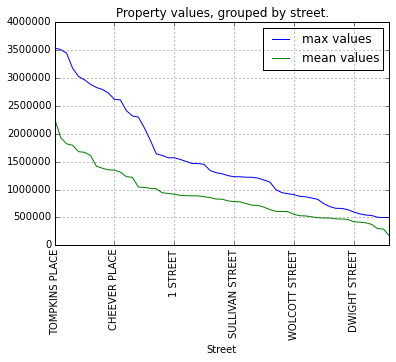

In [152]:
import matplotlib.pyplot as plt

max09_str.plot(label="max values")
mean09_str.plot(label="mean values")

plt.legend(loc="best")
plt.title("Property values, grouped by street.")
plt.xticks(rotation=90)


## Let's choose the street with the highest standard deviation<br>Haves and nots.

In [186]:
grp09_str["Current Total Market Value"].std().order(ascending=False)[:10]


Street
KANE STREET         678945.611802
TOMPKINS PLACE      677017.691262
RAPELYE STREET      619836.806479
CLINTON STREET      619010.685420
BUTLER STREET       597896.937914
CARROLL STREET      578602.890832
PRESIDENT STREET    578519.788763
DE GRAW STREET      534861.894670
UNION STREET        524319.869057
2 PLACE             495189.824648
Name: Current Total Market Value, dtype: float64

### The block party at the 200's is where you wanna be.

In [194]:
df09_zip11231_subcols.columns

kane_std = df09_zip11231_subcols[df09_zip11231_subcols.Street == "KANE STREET"][
        ["Current Total Market Value", "Owner", "Lowest House Number" ]].\
        sort_index(by="Current Total Market Value", ascending=False)
pd.set_option("display.max_rows", 10)
kane_std

,Current Total Market Value,Owner,Lowest House Number
24,3177000,JAMES BODE,000000000235
23,2911000,CARA GAVIN,000000000239
31,2824000,DONALD P SCHENK,000000000219
28,2809000,THOMAS O BOUCHER,000000000225
29,2809000,"MELAMED, MARK A",000000000223
...,...,...,...
49,1022000,"KANAS, JENNIFER",000000000090
15,994000,"BILGER, KARINA",000000000129
3,837000,SUTTON ALBERT,000000000111
100,781000,"MILDE, CLAIBORNE",000000000140


# python client for enigma.io API - for now it just provides "export" support

In [ ]:
#!/usr/bin/env python

import os
import sys
import time
import argparse
import requests
from requests import RequestException

ARGPARSER = argparse.ArgumentParser()
ARGPARSER.add_argument("datapath")
ARGPARSER.add_argument("-o", "--outfname", dest="outfname", required=False)


class EnigmaClient:
    ENIG_RETCODE_SUCCESS = 0
    ENIG_RETCODE_TIMEOUT = 1
    ENIG_RETCODE_ERROR   = 2

    _QUERY_TEMPLATE = "https://api.enigma.io/v2/{op}/{key}/{datapath}/{params}"
    _EXPORTAPI_MAX_SECS_TIMEOUT = 120
    _EXPORTAPI_POLL_SECS_INTERVAL = 1
    _EXPORTAPI_CHUNK_SIZE = 1024 * 64

    def __init__(self, apikey):
        self.apikey = apikey


    # Tables are exported as Gzipped CSV files. 
    # 
    # Exports of large tables may take some time, so exports are processed
    # asynchronously.
    # 
    # When the export API is called, an export is queued and the API immediately
    # returns a URL pointing to the future location of the exported file. Users
    # should poll the URL until the file becomes available.
    # 
    # Note: this is a synchronous call. Caller waits (up to max_secs_timeout)
    #       until data is made available by Enigma backend, and then downloaded.
    #       Caller should check err_code if the export fails.
    # 
    # Returns one of: ENIG_RETCODE_SUCCESS, ENIG_RETCODE_TIMEOUT, ENIG_RETCODE_ERROR
    # 
    def export(self, datapath, parameters=None,
               max_secs_timeout=None, outfname=None):

        query_str = self._QUERY_TEMPLATE.format(op="export", key=self.apikey,
                                                datapath=datapath, params="")
        # make a query, which sends back the URL that we'll have to poll
        # until it eventually responds back with the gzipped csv file.
        resp = requests.get(query_str)
        resp_json = resp.json()
        export_url = resp_json["export_url"]

        if not outfname:
            # derive it from the URL
            outfname = export_url[export_url.strip("/").rfind("/")+1:]
            if "?" in outfname:
                outfname = outfname[:outfname.rfind("?")]

        return self._download_file(export_url, outfname)
        
    def _download_file(self, export_url, outfname):
        timeout_secs_remaining = self._EXPORTAPI_MAX_SECS_TIMEOUT
        poll_time_interval = self._EXPORTAPI_POLL_SECS_INTERVAL

        completed = False
        print("About to attempt exporting export URL: {}".format(export_url))
        while (not completed) and (timeout_secs_remaining > 0):
            print("Retries timeout remaining: {} secs".format(timeout_secs_remaining))
            try:
                resp = requests.get(export_url, stream=True)
                if resp.ok is True:
                    with open(outfname, 'wb') as fout:
                        for chunk in resp.iter_content(
                                chunk_size=self._EXPORTAPI_CHUNK_SIZE): 
                            if chunk: # filter out keep-alive new chunks
                                fout.write(chunk)
                                fout.flush()
                    completed = True
                else:
                    print("Still polling. Response status_code: {} - Reason: {}".format(
                        resp.status_code, resp.reason))
            except Exception as exc:
                print("exc: {}".format(exc))
            finally:
                if not completed:
                    time.sleep(poll_time_interval)
                    timeout_secs_remaining -= poll_time_interval

        if completed is True:
            return self.ENIG_RETCODE_SUCCESS
        elif timeout_secs_remaining < 0:
            return self.ENIG_RETCODE_TIMEOUT
        else:
            return self.ENIG_RETCODE_ERROR

        
def main(apikey, args):
    # just getting started. For now there's only functionality to "export".
    client = EnigmaClient(apikey)
    client.export(args.datapath, outfname=args.outfname)


if __name__ == "__main__":
    apikey = os.getenv("ENV_ENIGMA_APIKEY")
    if not apikey:
        print('Please set your env var "ENV_ENIGMA_APIKEY"')
        sys.exit(1)
    
    main(apikey, ARGPARSER.parse_args())
